In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
from matplotlib import pyplot as plt
from pettingzoo.atari import space_invaders_v2
from pettingzoo.sisl import pursuit_v4

# DQN with paramater sharing between agents

In [5]:
class DQN(nn.Module):

    def __init__(self, n_states, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_states, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = nn.Linear(64,n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x

    
class ReplayMemory(object):

    def __init__(self, capacity, Transition):
        self.memory = deque([], maxlen=capacity)
        self.Transition = Transition

    def push(self, *args):
        """Save a transition"""
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def eps_decay(itr,num_episodes, eps_start, eps_end):
    if itr>=num_episodes*3000:
        return eps_end
    else:
        return (eps_end - eps_start)*itr/(num_episodes*3000) + eps_start

def action(observation, eps, n_actions, policy_net):
    p = np.random.random()
    if p < eps:
        a = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)
    else:
        a = policy_net(observation).max(1)[1].view(1, 1)

    return a


def update_network(policy_net, target_net, optimizer, memory, env, eps, batch_size, Transition, gamma):
    if len(memory) < batch_size:
        return

    batch_data = memory.sample(batch_size)

    batch = Transition(*zip(*batch_data))
    
    #state_batch = torch.cat([image.unsqueeze(0) for image in batch.state], dim=0)
    state_batch = torch.cat(batch.state)
    #print("State Batch Size:", state_batch.size())
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    dones_batch = torch.tensor([float(b) for b in batch.done])
    #dones_batch = torch.where(batch.done, torch.tensor(1), torch.tensor(0))
    #next_state_batch = torch.cat([image.unsqueeze(0) for image in batch.next_state], dim=0)
    next_state_batch = torch.cat(batch.next_state)
    #print("Next State Batch Size:", next_state_batch.size())

    Q_s_a = policy_net(state_batch).gather(1, action_batch)

    y_js = torch.zeros(batch_size)


    with torch.no_grad():
        y_js = (target_net(next_state_batch).max(1)).values
        y_js = reward_batch + (1-dones_batch)*gamma*y_js
        
    y_js = y_js.float()
        

    criterion = nn.MSELoss()

    loss = criterion(Q_s_a, y_js.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def train_network(num_episodes, policy_net, target_net, optimizer, memory, env, n_actions,
                    batch_size, eps_start, eps_end, gamma, Transition):
    reward_array = np.zeros(num_episodes)
    itr = 0
    for i_episode in range(num_episodes):
        print(i_episode,"th is running")
        # Initialize the environment and get it's state
        env.reset()
        time = 0
        termination = False 
        truncation = False
        for agent in env.agent_iter():
#             if time%500 == 0:
#                 print("Time:",time)
            eps = eps_decay(itr,num_episodes, eps_start, eps_end)
            observation, r, termination, truncation, info = env.last()
            observation = torch.tensor(observation).to(torch.float)
            observation = (torch.flatten(observation)).unsqueeze(0)
            #observation = observation.permute(2, 0, 1)
            if termination or truncation:
                a = None
            else:
                a = action(observation, eps, n_actions, policy_net)
            
            env.step(a.item())
            
            observation_next, r, termination, truncation, info = env.last()

            r = torch.tensor([r])
            reward_array[i_episode] += r
            time += 1

            observation_next = torch.tensor(observation_next).to(torch.float)
            observation_next = (torch.flatten(observation_next)).unsqueeze(0)
            #observation_next = observation_next.permute(2, 0, 1)

            memory.push(observation, a, observation_next, r, termination or truncation)

#             # Move to the next state
#             s = s_next

            # Perform one step of the optimization (on the policy network)
            update_network(policy_net, target_net, optimizer, memory, env, eps, batch_size, Transition, gamma)

            itr+=1

            if itr%5000 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            if time>=3000:
                break

    return policy_net, reward_array

# Evaders are free to move

In [8]:
batch_size = 32
gamma = 1
eps_start = 1
eps_end = 0.1
num_episodes = 300
n_actions = 5

env = pursuit_v4.env(max_cycles=500, x_size=16, y_size=16, shared_reward=True, n_evaders=25,
n_pursuers=6,obs_range=7, n_catch=2, freeze_evaders=False, tag_reward=0.01,
catch_reward=5.0, urgency_reward=0, surround=True, constraint_window=1.0)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

policy_net = DQN(3*7*7, n_actions)
target_net = DQN(3*7*7, n_actions)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.00025, alpha=0.95)
memory = ReplayMemory(1000000, Transition)

policy_net, reward_array = train_network(num_episodes, policy_net, target_net, optimizer, memory, env, n_actions, batch_size, eps_start, eps_end, gamma, Transition)

0 th is running
1 th is running
2 th is running
3 th is running
4 th is running
5 th is running
6 th is running
7 th is running
8 th is running
9 th is running
10 th is running
11 th is running
12 th is running
13 th is running
14 th is running
15 th is running
16 th is running
17 th is running
18 th is running
19 th is running
20 th is running
21 th is running
22 th is running
23 th is running
24 th is running
25 th is running
26 th is running
27 th is running
28 th is running
29 th is running
30 th is running
31 th is running
32 th is running
33 th is running
34 th is running
35 th is running
36 th is running
37 th is running
38 th is running
39 th is running
40 th is running
41 th is running
42 th is running
43 th is running
44 th is running
45 th is running
46 th is running
47 th is running
48 th is running
49 th is running
50 th is running
51 th is running
52 th is running
53 th is running
54 th is running
55 th is running
56 th is running
57 th is running
58 th is running
59 th i

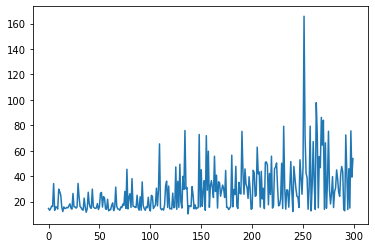

In [9]:
plt.plot(reward_array)

In [9]:
class DQN(nn.Module):

    def __init__(self, n_states, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_states, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = nn.Linear(64,n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x

    
class ReplayMemory(object):

    def __init__(self, capacity, Transition):
        self.memory = deque([], maxlen=capacity)
        self.Transition = Transition

    def push(self, *args):
        """Save a transition"""
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def eps_decay(itr,num_episodes, eps_start, eps_end):
    if itr>=num_episodes*3000:
        return eps_end
    else:
        return (eps_end - eps_start)*itr/(num_episodes*3000) + eps_start

def action(observation, eps, n_actions, policy_net):
    p = np.random.random()
    if p < eps:
        a = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)
    else:
        a = policy_net(observation).max(1)[1].view(1, 1)

    return a


def update_network(policy_net, target_net, optimizer, memory, env, eps, batch_size, Transition, gamma):
    if len(memory) < batch_size:
        return

    batch_data = memory.sample(batch_size)

    batch = Transition(*zip(*batch_data))
    
    #state_batch = torch.cat([image.unsqueeze(0) for image in batch.state], dim=0)
    state_batch = torch.cat(batch.state)
    #print("State Batch Size:", state_batch.size())
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    dones_batch = torch.tensor([float(b) for b in batch.done])
    #dones_batch = torch.where(batch.done, torch.tensor(1), torch.tensor(0))
    #next_state_batch = torch.cat([image.unsqueeze(0) for image in batch.next_state], dim=0)
    next_state_batch = torch.cat(batch.next_state)
    #print("Next State Batch Size:", next_state_batch.size())

    Q_s_a = policy_net(state_batch).gather(1, action_batch)

    y_js = torch.zeros(batch_size)


    with torch.no_grad():
        y_js = (target_net(next_state_batch).max(1)).values
        y_js = reward_batch + (1-dones_batch)*gamma*y_js
        
    y_js = y_js.float()
        

    criterion = nn.MSELoss()

    loss = criterion(Q_s_a, y_js.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def train_network(num_episodes, policy_net, target_net, optimizer, memory, env, n_actions,
                    batch_size, eps_start, eps_end, gamma, Transition):
    reward_array = np.zeros(num_episodes)
    itr = 0
    for i_episode in range(num_episodes):
        print(i_episode,"th is running")
        # Initialize the environment and get it's state
        env.reset()
        time = 0
        termination = False 
        truncation = False
        for agent in env.agent_iter():
#             if time%500 == 0:
#                 print("Time:",time)
            eps = eps_decay(itr,num_episodes, eps_start, eps_end)
            observation, r, termination, truncation, info = env.last()
            observation = torch.tensor(observation).to(torch.float)
            observation = (torch.flatten(observation)).unsqueeze(0)
            #observation = observation.permute(2, 0, 1)
            if termination or truncation:
                a = None
            else:
                a = action(observation, eps, n_actions, policy_net)
            
            env.step(a.item())
            
            observation_next, r, termination, truncation, info = env.last()

            r = torch.tensor([r])
            reward_array[i_episode] += r
            time += 1

            observation_next = torch.tensor(observation_next).to(torch.float)
            observation_next = (torch.flatten(observation_next)).unsqueeze(0)
            #observation_next = observation_next.permute(2, 0, 1)

            memory.push(observation, a, observation_next, r, termination or truncation)

#             # Move to the next state
#             s = s_next

            # Perform one step of the optimization (on the policy network)
            update_network(policy_net, target_net, optimizer, memory, env, eps, batch_size, Transition, gamma)

            itr+=1

            if itr%30000 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            if time>=3000:
                break

    return policy_net, reward_array

batch_size = 32
gamma = 1
eps_start = 1
eps_end = 0.1
num_episodes = 300
n_actions = 5

env = pursuit_v4.env(max_cycles=500, x_size=16, y_size=16, shared_reward=True, n_evaders=25,
n_pursuers=6,obs_range=7, n_catch=2, freeze_evaders=False, tag_reward=0.01,
catch_reward=5.0, urgency_reward=0, surround=True, constraint_window=1.0)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

policy_net = DQN(3*7*7, n_actions)
target_net = DQN(3*7*7, n_actions)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.00025, alpha=0.95)
memory = ReplayMemory(1000000, Transition)

policy_net, reward_array = train_network(num_episodes, policy_net, target_net, optimizer, memory, env, n_actions, batch_size, eps_start, eps_end, gamma, Transition)

0 th is running
1 th is running
2 th is running
3 th is running
4 th is running
5 th is running
6 th is running
7 th is running
8 th is running
9 th is running
10 th is running
11 th is running
12 th is running
13 th is running
14 th is running
15 th is running
16 th is running
17 th is running
18 th is running
19 th is running
20 th is running
21 th is running
22 th is running
23 th is running
24 th is running
25 th is running
26 th is running
27 th is running
28 th is running
29 th is running
30 th is running
31 th is running
32 th is running
33 th is running
34 th is running
35 th is running
36 th is running
37 th is running
38 th is running
39 th is running
40 th is running
41 th is running
42 th is running
43 th is running
44 th is running
45 th is running
46 th is running
47 th is running
48 th is running
49 th is running
50 th is running
51 th is running
52 th is running
53 th is running
54 th is running
55 th is running
56 th is running
57 th is running
58 th is running
59 th i

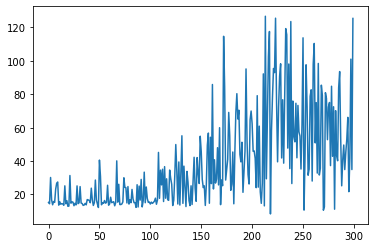

In [19]:
plt.plot(reward_array)

In [20]:
class DQN(nn.Module):

    def __init__(self, n_states, n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_states, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = nn.Linear(64,n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x

    
class ReplayMemory(object):

    def __init__(self, capacity, Transition):
        self.memory = deque([], maxlen=capacity)
        self.Transition = Transition

    def push(self, *args):
        """Save a transition"""
        self.memory.append(self.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def eps_decay(itr,num_episodes, eps_start, eps_end):
    if itr>=num_episodes*3000:
        return eps_end
    else:
        return (eps_end - eps_start)*itr/(num_episodes*3000) + eps_start

def action(observation, eps, n_actions, policy_net):
    p = np.random.random()
    if p < eps:
        a = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)
    else:
        a = policy_net(observation).max(1)[1].view(1, 1)

    return a


def update_network(policy_net, target_net, optimizer, memory, env, eps, batch_size, Transition, gamma):
    if len(memory) < batch_size:
        return

    batch_data = memory.sample(batch_size)

    batch = Transition(*zip(*batch_data))
    
    #state_batch = torch.cat([image.unsqueeze(0) for image in batch.state], dim=0)
    state_batch = torch.cat(batch.state)
    #print("State Batch Size:", state_batch.size())
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    dones_batch = torch.tensor([float(b) for b in batch.done])
    #dones_batch = torch.where(batch.done, torch.tensor(1), torch.tensor(0))
    #next_state_batch = torch.cat([image.unsqueeze(0) for image in batch.next_state], dim=0)
    next_state_batch = torch.cat(batch.next_state)
    #print("Next State Batch Size:", next_state_batch.size())

    Q_s_a = policy_net(state_batch).gather(1, action_batch)

    y_js = torch.zeros(batch_size)


    with torch.no_grad():
        y_js = (target_net(next_state_batch).max(1)).values
        y_js = reward_batch + (1-dones_batch)*gamma*y_js
        
    y_js = y_js.float()
        

    criterion = nn.MSELoss()

    loss = criterion(Q_s_a, y_js.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def train_network(num_episodes, policy_net, target_net, optimizer, memory, env, n_actions,
                    batch_size, eps_start, eps_end, gamma, Transition):
    reward_array = np.zeros(num_episodes)
    itr = 0
    for i_episode in range(num_episodes):
        print(i_episode,"th is running")
        # Initialize the environment and get it's state
        env.reset()
        time = 0
        termination = False 
        truncation = False
        for agent in env.agent_iter():
#             if time%500 == 0:
#                 print("Time:",time)
            eps = eps_decay(itr,num_episodes, eps_start, eps_end)
            observation, r, termination, truncation, info = env.last()
            observation = torch.tensor(observation).to(torch.float)
            observation = (torch.flatten(observation)).unsqueeze(0)
            #observation = observation.permute(2, 0, 1)
            if termination or truncation:
                a = None
            else:
                a = action(observation, eps, n_actions, policy_net)
            
            env.step(a.item())
            
            observation_next, r, termination, truncation, info = env.last()

            r = torch.tensor([r])
            reward_array[i_episode] += r
            time += 1

            observation_next = torch.tensor(observation_next).to(torch.float)
            observation_next = (torch.flatten(observation_next)).unsqueeze(0)
            #observation_next = observation_next.permute(2, 0, 1)

            memory.push(observation, a, observation_next, r, termination or truncation)

#             # Move to the next state
#             s = s_next

            # Perform one step of the optimization (on the policy network)
            update_network(policy_net, target_net, optimizer, memory, env, eps, batch_size, Transition, gamma)

            itr+=1

            if itr%30000 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            if time>=3000:
                break

    return policy_net, reward_array

batch_size = 32
gamma = 1
eps_start = 1
eps_end = 0.1
num_episodes = 500
n_actions = 5

env = pursuit_v4.env(max_cycles=500, x_size=16, y_size=16, shared_reward=True, n_evaders=25,
n_pursuers=6,obs_range=7, n_catch=2, freeze_evaders=False, tag_reward=0.01,
catch_reward=5.0, urgency_reward=0, surround=True, constraint_window=1.0)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

policy_net = DQN(3*7*7, n_actions)
target_net = DQN(3*7*7, n_actions)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.00025, alpha=0.95)
memory = ReplayMemory(1000000, Transition)

policy_net_2, reward_array_2 = train_network(num_episodes, policy_net, target_net, optimizer, memory, env, n_actions, batch_size, eps_start, eps_end, gamma, Transition)

0 th is running
1 th is running
2 th is running
3 th is running
4 th is running
5 th is running
6 th is running
7 th is running
8 th is running
9 th is running
10 th is running
11 th is running
12 th is running
13 th is running
14 th is running
15 th is running
16 th is running
17 th is running
18 th is running
19 th is running
20 th is running
21 th is running
22 th is running
23 th is running
24 th is running
25 th is running
26 th is running
27 th is running
28 th is running
29 th is running
30 th is running
31 th is running
32 th is running
33 th is running
34 th is running
35 th is running
36 th is running
37 th is running
38 th is running
39 th is running
40 th is running
41 th is running
42 th is running
43 th is running
44 th is running
45 th is running
46 th is running
47 th is running
48 th is running
49 th is running
50 th is running
51 th is running
52 th is running
53 th is running
54 th is running
55 th is running
56 th is running
57 th is running
58 th is running
59 th i

462 th is running
463 th is running
464 th is running
465 th is running
466 th is running
467 th is running
468 th is running
469 th is running
470 th is running
471 th is running
472 th is running
473 th is running
474 th is running
475 th is running
476 th is running
477 th is running
478 th is running
479 th is running
480 th is running
481 th is running
482 th is running
483 th is running
484 th is running
485 th is running
486 th is running
487 th is running
488 th is running
489 th is running
490 th is running
491 th is running
492 th is running
493 th is running
494 th is running
495 th is running
496 th is running
497 th is running
498 th is running
499 th is running


Text(0, 0.5, 'Return')

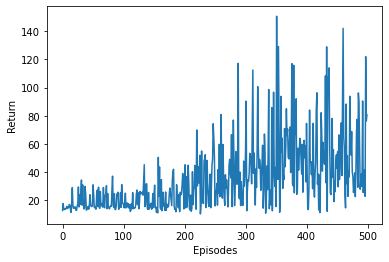

In [22]:
plt.plot(reward_array_2)
plt.xlabel("Episodes")
plt.ylabel("Return")

In [23]:
torch.save(policy_net_2.state_dict(), "DQN_combined_500")

In [ ]:
batch_size = 32
gamma = 1
eps_start = 1
eps_end = 0.1
num_episodes = 1000
n_actions = 5

env = pursuit_v4.env(max_cycles=500, x_size=16, y_size=16, shared_reward=True, n_evaders=25,
n_pursuers=6,obs_range=7, n_catch=2, freeze_evaders=False, tag_reward=0.01,
catch_reward=5.0, urgency_reward=0, surround=True, constraint_window=1.0)

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

policy_net = DQN(3*7*7, n_actions)
target_net = DQN(3*7*7, n_actions)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.00025, alpha=0.95)
memory = ReplayMemory(1000000, Transition)

policy_net_3, reward_array_3 = train_network(num_episodes, policy_net, target_net, optimizer, memory, env, n_actions, batch_size, eps_start, eps_end, gamma, Transition)

0 th is running
1 th is running
2 th is running
3 th is running
4 th is running
5 th is running
6 th is running
7 th is running
8 th is running
9 th is running
10 th is running
11 th is running
12 th is running
13 th is running
14 th is running
15 th is running
16 th is running
17 th is running
18 th is running
19 th is running
20 th is running
21 th is running
22 th is running
23 th is running
24 th is running
25 th is running
26 th is running
27 th is running
28 th is running
29 th is running
30 th is running
31 th is running
32 th is running
33 th is running
34 th is running
35 th is running
36 th is running
37 th is running
38 th is running
39 th is running
40 th is running
41 th is running
42 th is running
43 th is running
44 th is running
45 th is running
46 th is running
47 th is running
48 th is running
49 th is running
50 th is running
51 th is running
52 th is running
53 th is running
54 th is running
55 th is running
56 th is running
57 th is running
58 th is running
59 th i